In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

# 為你寫詩 (pytorch)

支援python 版本: 3.5以上  
支援pytorch版本 : 1.2以上

詩詞歌賦是人類語言的精華，若要說什麼是語言能力最高的表現，那大概就是寫詩或是寫小說了。我們今天就要來嘗試讓機器也能夠生成詩詞歌賦，不過大家不要以為AI已經攻破了這個任務，相反的，人工智能在語言這條路上還有許多路得走，今天的實作機器所寫出來的與其說是創作，倒不如說是鸚鵡學舌來的貼切，機器的確能在大量語料中學習到語言的部分語義，搭配LSTM這個專門用於序列數據的算法，還是能夠產生一些蠻有趣的內容。

![Alt text](../images/tang-shi.jpg)

In [2]:
import os
os.environ['TRIDENT_BACKEND'] = 'pytorch'

#!pip uninstall tridentx
#!pip install tridentx --upgrade
from trident import *

trident 0.7.3


Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Pytorch version:1.7.1+cu110.
Automatic Mixed Precision Support:True.


Opencv version:4.1.2.
Pillow version:8.2.0.


目前所有AI都是基於數據所驅動，因此我準備了6份語料，大家都可以套用在這次介紹的架構中進行訓練與推論，您也可以換成自己準備的語料文字檔(請注意需要有足夠數量才能夠訓練得夠好。)

item='jay' #周杰倫歌詞   
item='lingxi' #林夕歌詞   
item='poets54' #五言絕句   
item='poets74' #七言絕句   
item='poets58' #五言律詩  
item='poets78' #七言律詩  

## 為你寫歌詞

我們先從難度較低的開始著手，那就先用周董的歌吧。

In [3]:
item='jay' 
data_provider,original_corpus=load_text(item+'.txt',unit='char',mode='next_word',is_onehot=False,sequence_length=16,return_corpus=True,sequence_start_at='random')
#全形轉半形
data_provider.traindata.data.transform_funcs=[
    ToHalfWidth()
    ]



t1,t2=data_provider.next()

total distinct chars: 2492
total distinct chars: 2492


在準備資料方面，我所設計的trident api中其實是透過TextSequenceDataset(負責儲存語料，以及將語料轉換為序列張量)以及TextSequenceDataProvider(作為提供數據的generator，負責供應數據的接口)這兩個物件來負責的。其中只需要透過比較簡單的load_text函數就可以設計好前述兩者的設定。loadtext的設定引數如下：

     filname (str)  :文字檔案來源的路徑
     data (str,list): 輸入語料
     label (str,list): 輸出語料
     unit (str)     :文字分割的基礎，有效值包括'char'(字)以及'word'(詞)，預設為'char'，目前中文尚不支援自動分詞
     mode (str)     :產生序列模式，有效值包括'next_word'(預測下一個字),skip_gram(前後文預測當前字元),cbow(當前字元預測前後文),
                     onehot(產生onehot向量),1to1_seq2seq (一對一序列對序列)
     section_delimiter (str): 分區的分隔符號，為了避免撞號，因此要求需要使用連續兩個字元作為分隔符號，預測為'\n\n'
     sequence_start_at (str)：序列起始點選取方法，有效值包括'random'(隨機起始)，'slide'(活動窗口，意味著前後序列可能重疊)
                     ,'follow_up'(接續，前後序列不重疊),'section_start'(以每個分段起點作為開始)
     is_onehot(bool): 是否為onehot
     encoding       :編碼，目前預設值為'utf-8-sig':
     sequence_length (int) :序列長度，預設值為64
     return_corpus(bool)   : 除了data provider外是否回傳原始語料



其中為何在自動寫歌詞的 **sequence_start_at** 要設定為 **random**呢?最主要是現代歌詞比較沒有固定格律，每句長短也不一，如果使用section_start，則句末會以 **[PAD]** 填滿，這在我們日後生成文字時會造成困擾(除非序列定長，否則我們無法預期PAD何時結束)，所以我們採取序列取樣方法為 **random** 這樣可以強化模型不需要句子從頭開始完整語意仍可預測序列的能力，而且設定的序列長度較短，也避免[PAD]的發生。

我們將data_provider提供的數據根據它自身的index2text方法還原，各位可以看到它除了語料本身之外，還額外插入了**[CLS],[SEP],[PAD]**等標籤，以作為文字分段的基礎參考。

In [4]:
for k in range(8):
    print(''.join([data_provider.index2text(i) if i!=3 else '' for i in t1[k]]))
    print(''.join([data_provider.index2text(i) if i!=3 else '' for i in t2[k]]))
    print('')
    
print(''.join(data_provider.vocabs))
print(data_provider.signature)


不知不覺[SEP][CLS]我跟了這節奏[SEP][CLS]後知
知不覺[SEP][CLS]我跟了這節奏[SEP][CLS]後知後

我都要活的很驕傲[SEP][CLS]我說自尊那 
都要活的很驕傲[SEP][CLS]我說自尊那 看

[CLS]我送你離開[SEP][CLS]天涯之外[SEP][CLS]你是
我送你離開[SEP][CLS]天涯之外[SEP][CLS]你是否

他們咬著蘋果 手裡拿著長鏡頭[SEP][CLS]
們咬著蘋果 手裡拿著長鏡頭[SEP][CLS]好

美女需要我[SEP][CLS]牛仔很忙的[SEP]
女需要我[SEP][CLS]牛仔很忙的[SEP]

塵埃[SEP][CLS](等待)竟累積成傷害[SEP][CLS]
埃[SEP][CLS](等待)竟累積成傷害[SEP][CLS]轉

著歌 一直走[SEP][CLS]我想就這樣牽著你
歌 一直走[SEP][CLS]我想就這樣牽著你的

人喜歡摔吉他 (吉他)[SEP][CLS]有種你
喜歡摔吉他 (吉他)[SEP][CLS]有種你就

[CLS][SEP][UNK][PAD][MASK]
 ()*,-./12389:?[]`abcdefghijklmnoprstuvwxyz~·…☆。〇《》〖〗ーㄇㄈㄌㄒㄙㄚㄟㄡ一丁七三上下不丑世丘丟並中丸丹主久之乎乒乓乖乘九也乾亂了予事二互五井亙些亞亡交亦享亭亮人什仁仇今介仍仔仕他仗付仙代令以仰件任份仿伊伏伐休伯伱伴伸似伽但佇佈位低住佔何佗佛作你佳佻使來供依侵便係促俊保俠信俯俺倉個們倒倔候借倦倫倭值假偉偎偏做停側偵偶偷偽傀傅傍傑傘備傲傳債傷傻傾像僵價儀儂儘儡優儲兀元兄充兆兇先光克免兒兜入內全兩八公六兮共兵其具典冉冊再冒冠冥冬冰冷准凋凝凡凱凶出刀分切刊列初判別利刪刮到制刷刺刻則削前剔剛剝剩剪副割創劃劇劍力功加助努劫勇勉勒動務勝勞勢勵勾包匆化北匙匠匹區十千升午半卑協南卜占卡卦印危即卷卸卻厚原厭厲去參又及友反叔取受叛叢口古句另叨叩只叫叭叮可台史右司吃吆合吉吊同名吐向君吝吞吟吠否吧含吭吳吵吸吹吻吼吾呀呆告呢呦周味呵呸呼命咆和咒咖咧咩咪咬咱咸咿哀品哈哉哎哥哦哩哪哭哮哼唇唐唯唰唱唸啃啊問啜啞啡啤啥啦啵喂善喇喉喊喔喘喚喜喝喧喪喬單喲嗅嗇嗎嗓嗚嗜嗦嗨嘆嘗嘛嘟嘯嘲嘴嘶嘿噙噠噢器噬噴噹嚇嚎嚴囂囉四回因囪困固圈國圍園圓圖團土在地圾坊坐坑坡坦垂垃型埃埋城培基堂堅堆堡堤堪報場堵塊塌塔塗

這次要實作的模型說是機器寫作，其實本質就是要機器基於已經知道的序列內容，預測下一個字。所以這種一個字一個字生成的模式，來構築出整個內容。這個也是深度學習語言模型中最基礎的Char-rnn。

![Alt text](../images/unlimited_monkey.jpg)

數學上有個「無限猴子理論」，說是給猴子一台打字機，只要給他無限的時間，總有一天可以打出莎士比亞全集。這樣講有點作弊，看來得是要等到猴子進化成人類後才寫得出來。期待猴子實在沒可能，那我們能否寄望神經網路呢?當然可以，我們將會示範如何透過lstm來讓機器能夠吟詩作賦。以下是這次的char-cnn的結構以及每個階段的張量尺寸。


![Alt text](../images/char_rnn.png)

模型結構就如同前圖所介紹的，我們預計將透過是將文字張量，先通過Embedding層抽取表徵，經過正規化之後直接導入至LSTM中，輸出的結果需要reshape在經過正規化以及全連接層，就可以輸出下一個字的預測值。

In [5]:
h_size=512
num_chars=len(data_provider.vocabs)


lstm1=Sequential(
    Embedding(embedding_dim=256,num_embeddings=num_chars,sparse=False,name='embed'),
    BatchNorm(in_sequence=True),
    LSTM(hidden_size=h_size,num_layers=2,stateful=False,batch_first=False,dropout_rate=0.2, name='lstm'),
    Reshape((h_size)),
    Dense(num_chars,use_bias=False,activation=None, name='fc'),
    SoftMax(-1,name='softmax')
    
)


我們將模型利用前面provider供應的數據作為範例資料來指定輸入與輸出，這樣就完成了模型結構設計。

In [6]:

lstm_jay=Model(inputs=t1,output=lstm1)


#if os.path.exists('Models/{0}.pth.tar'.format(item)):
#    lstm_jay.load_model('Models/{0}.pth.tar'.format(item))
lstm_jay.summary()

--------------------------------------------------------------------------------------------------------------------------------
   Layer (type)     Output Shape               Weight                           Bias      Param #   FLOPS #                  
0  [Embedding]      [None, 16, 256]            'weight', [2492, 256]                      637,952  326,631,168  
1  [BatchNorm]      [None, 16, 256]            'weight', [256]                  'bias', [256]  512  261,632  
2  [LSTM]           [None, 16, 512]            'weight_ih_l0', [2048, 256]                3,670,016  3,758,094,336  
                                                          'weight_hh_l0', [2048, 512]                      
                                                          'weight_ih_l1', [2048, 512]                      
                                                          'weight_hh_l1', [2048, 512]                      
3  [Reshape]        [None, 512]                                                  

Model(
  (inputs): TensorSpec(dtype=torch.int64, shape=(None, 16), ndim=2, name=input)
  (_outputs): TensorSpec(shape=(None, 2492), ndim=2, name=output)
)

在這個文字生成模型，本質上就是一個分類問題，根據前面的狀態評估下一個字是什麼，所以我們直接使用常見的CrossEntropyLoss就可以，但是別忘了，由於是在序列內，因此目標值的形狀會是 **(批次,序列長)**，這跟已經經過reshape層的輸出值不一樣，所以目標值也需要reshape一下。

In [7]:

def SequenceCrossEntropyLoss(output, target):
    target = target.reshape(-1)
    mask = target != 3
    masked_target = target[mask]
    masked_output = output[mask, :]
    return CrossEntropyLoss(reduction='mean', axis=-1)(masked_output, masked_target) + 0.2 * CrossEntropyLoss(reduction='mean', auto_balance=True, axis=-1)(output, target)


def SequenceAccuracy(output, target):
    target = target.reshape(-1)
    mask = target != 3
    masked_target = target[mask]
    masked_output = output[mask, :]
    return accuracy(masked_output, masked_target, axis=-1)

在最後模型的設定基本上是將剛才處理過的支持序列的CrossEntropyLoss以及Accuracy分別設定為損失函數與評估函數，為了避免LSTM梯度爆炸(理論上很少發生，但是以防萬一)，我加上了**梯度裁切(gradient clipping)**，然後我希望在模型訓練過程中可以即時看到預測的效果，因此我們需要讓訓練流程中定期調用剛剛寫好的write_something函數，以前是需要透過客製化Callbacks的方式來實現，**現在在trident中有更簡單的新方法就是使用模型中的trigger_when方法**。透過trigger_when的action(對應到輸入值為training_context的函數)以及設定基於什麼來觸發action的事件，舉例來說，我希望每500個批次就調用一次write_something函數，因此就可以設定在on_batch_end事件中觸發，不過每次觸發時，可以透過檢查training_context中目前的epoch以及batch數來判斷是否要繼續執行，這樣等於不需要重新撰寫callbacks類，就能做到同樣的效果。

In [8]:

def write_something(training_context):
    """

    :param training_context:
    :type training_context:
    """
    global data_provider, original_corpus,item

    model =copy.deepcopy( training_context['current_model'])
    # 模型千萬記得要轉換成eval模式
    model.eval()
    for  module in model.modules():
        if isinstance(module, LSTM):
            module.stateful=True


    print()
    temperatures =[0.8,1.0,1.2,1.5,1.8]
    for k in range(5):
        temperature=temperatures[k]
        #清除模型狀態
        for module in model.modules():
            if isinstance(module, LSTM):
                module.clear_state()

        model.eval()
        text_generated = []
        start_string = random_choice(original_corpus)[:1]
        text_generated.append('[CLS]')
        text_generated.extend(list(start_string))


        seq = [data_provider.text2index(s) for s in start_string]
        seq.insert(0, 0)
        # seq.append(1)
        input_eval = to_tensor([seq]).long().detach()
        if ndim(input_eval)<2:
            input_eval=input_eval.expand_dims(0)

        print('----- temperature:', temperature)
        print('----- 根據以下詞彙發想:「{0}」'.format(start_string))
        print('')
        is_finished = False
        num_generate = 0
        row_length=0

        sys.stdout.write(start_string)

        while not is_finished:
            try:

                predictions = model(input_eval)[-1]
                #將溫度設定僅限於機率最高的十個字
                predicted_idx=argsort(predictions)[:10]
                predicted_probs =  clip(predictions[predicted_idx],1e-8,1-1e-8)

                predicted_id = predicted_idx[multinomial(predicted_probs/ temperature, num_samples=1)].item()
                #predicted_id = argmax(predictions).item()

                # We pass the predicted word as the next input to the model
                # along with the previous hidden state
                input_eval = to_tensor([[predicted_id]]).long().detach()
                if ndim(input_eval) < 2:
                    input_eval = input_eval.expand_dims(0)

                text_generated.append(data_provider.index2text(predicted_id))

                if len(text_generated)>15 and len(list(set(text_generated[-10:])))==1:
                    is_finished = True
                    break
                if text_generated[-2] == '[SEP]' and text_generated[-1] == '[PAD]':
                    sys.stdout.write('\n')
                    is_finished=True
                    sys.stdout.flush()
                elif  text_generated[-2] == '\n' and text_generated[-1] == '\n':
                    sys.stdout.write('\n')
                    is_finished=True
                    sys.stdout.flush()
                elif text_generated[-2] == '[SEP]' and text_generated[-1]=='[CLS]':
                    sys.stdout.write('\n')
                    sys.stdout.flush()
                elif text_generated[-1] not in ['[CLS]', '[SEP]', '[PAD]', '[UNK]']:
                    sys.stdout.write(text_generated[-1])
                    row_length += 1
                    if item=='poets58'  and row_length >= 47 and text_generated[-1] in ['，', '。',' ', '[SEP]']:
                        sys.stdout.write('\n')
                        is_finished=True
                    sys.stdout.flush()
                num_generate += 1
                if num_generate > 500:
                    is_finished = True

            except Exception as e:
                print(e)
        print(' ')
        model.train()
        print()

既然說是文本生成模型，那當然推論階段是要能自動將文字內容產生出來，在此我們透過write_something函數，隨機從語料中抽取案例，利用他的頭幾個字作為提示來開始生成文本。在這個階段建議不要抽太多字，否則你會看到LSTM優異的...**背書能力**。由於背歌詞實在沒有什麼讓人太驚艷的，為了增加意外性，我們就不直接利用argmax找出最高機率位置的方式來生成文字，而是透過溫度的概念，**除以一個高於1的溫度值(降溫)搭配基於多項式機率分布**來抽樣，這樣其他非最高機率的字才有機會可以出線，這樣文字生成才不會變成背書大賽。而我是把傳統多項式機率分布的範圍從全部詞彙，改成機會最高的前十個字，以免傳統作法容易出現不通順的問題。

此外，還需要注意的是，在訓練過程中，由於我們沒有辦法確保每個批次之間是來自於同個作品，因此會設定stateful=False(這也是預設值)，這樣每個批次執行前會清掉初始隱藏狀態與內部狀態，但是在推論階段，由於我們是一次傳一個字，因此需要連續的狀態，因此要記得推論階段要把stateful設定為True。


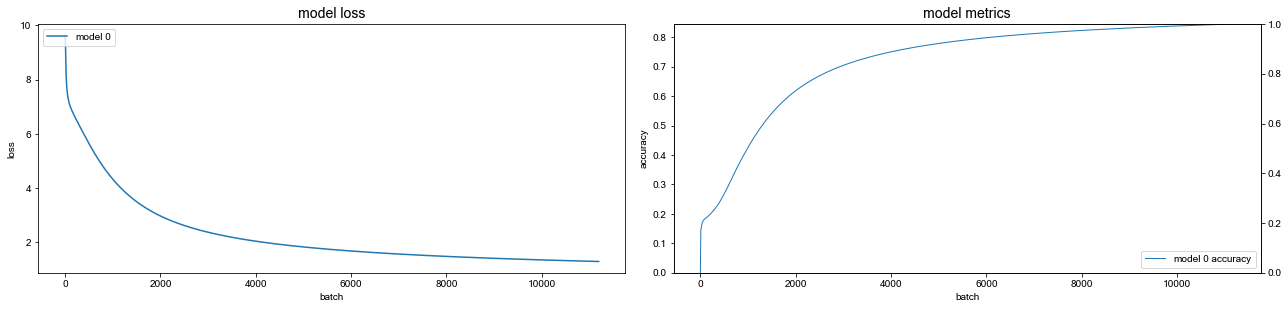

model 0           first_layer gradients: 1.121e+01| last_layer gradients: 2.316e+01
model 0      Step: 1s524ms  | Loss: 1.297 | accuracy: 84.469%  | lr: 1.000e-03  | epoch: 9  ( 1080/1125 )
model 0      Step: 1s395ms  | Loss: 1.297 | accuracy: 84.473%  | lr: 1.000e-03  | epoch: 9  ( 1090/1125 )
model 0      Step: 1s382ms  | Loss: 1.296 | accuracy: 84.478%  | lr: 1.000e-03  | epoch: 9  ( 1100/1125 )
model 0      Step: 1s396ms  | Loss: 1.296 | accuracy: 84.483%  | lr: 1.000e-03  | epoch: 9  ( 1110/1125 )
model 0      Step: 1s444ms  | Loss: 1.295 | accuracy: 84.488%  | lr: 1.000e-03  | epoch: 9  ( 1120/1125 )


In [9]:

lstm_jay\
    .with_optimizer(optimizer='Adam',lr=1e-3,betas=(0.9, 0.999))\
    .with_loss(SequenceCrossEntropyLoss)\
    .with_metric(SequenceAccuracy,name='accuracy')\
    .with_regularizer('l2')\
    .with_model_save_path('Models/{0}.pth.tar'.format(item))\
    .trigger_when('on_batch_end', action=write_something,frequency=500,unit='batch') \
    .with_learning_rate_scheduler(reduce_lr_on_plateau,monitor='accuracy',mode='max',factor=0.5,patience=2,cooldown=0,threshold=2e-3,warmup=0) \
    .with_automatic_mixed_precision_training()

    #.with_optimizer(optimizer='Adam',lr=1e-3,betas=(0.9, 0.999))\ 設定優化器
    #.with_loss(SequenceCrossEntropyLoss)\ 設定損失函數
    #.with_metric(SequenceAccuracy,name='accuracy')\ 設定評估函數
    #.with_regularizer('l2')\ 設定l2regularizer
    #.with_model_save_path('Models/{0}.pth.tar'.format(item))\ 設定模型存檔路徑
    #.trigger_when('on_batch_end', action=write_something) \ #設定觸發任務write_something
    #設定調整學習速率時程
    #.with_learning_rate_scheduler(reduce_lr_on_plateau,monitor='accuracy',mode='max',factor=0.5,patience=3,cooldown=0,threshold=5e-4,warmup=0) \
    #.with_automatic_mixed_precision_training() #設定為自動混合精度訓練

plan=TrainingPlan()\
    .add_training_item(lstm_jay)\
    .with_data_loader(data_provider)\
    .repeat_epochs(10)\
    .with_batch_size(64)\
    .print_progress_scheduling(10,unit='batch')\
    .display_loss_metric_curve_scheduling(frequency=200,unit='batch',imshow=True)\
    .print_gradients_scheduling(200)\
    .save_model_scheduling(100,unit='batch')

    #.add_training_item(lstm_jay)\ 加入要訓練的模型
    #.with_data_loader(data_provider)\ 設定資料提供者
    #.repeat_epochs(10)\  設定總epoch數
    #.with_batch_size(64)\ 設定批次大小
    #.print_progress_scheduling(20,unit='batch')\ 設定列印訓練狀態的時程
    #.display_loss_metric_curve_scheduling(frequency=200,unit='batch',imshow=True)\ 設定顯示loss-metrics時間走勢圖的時程
    #.print_gradients_scheduling(200)\ 設定列印梯度狀況的時程
    #.save_model_scheduling(100,unit='batch') 設定存檔的時程

plan.start_now()

## 為你寫唐詩

既然是「為你寫詩」，當然除了寫歌詞之外，還要挑戰更難一點的任務，那就是寫真正的詩，而且是唐詩的風格。我這邊分別準備了五言絕句(poets54.txt，共4065首)、七言絕句(poets74.txt，共10730首)、五言律詩(poets58.txt，共14409首)、七言律詩(poets78.txt，共8180首)這四種語料，我們就來挑戰語料量最豐富的五言律詩。

In [10]:
item='poets58' 

data_provider,original_corpus=load_text(item+'.txt',unit='char',is_onehot=False,sequence_length=50,sequence_start_at='section_start',return_corpus=True)
t1,t2=data_provider.next()

for k in range(8):
    print(''.join([data_provider.index2text(i) if i!=3 else '' for i in t1[k]]))
    print(''.join([data_provider.index2text(i) if i!=3 else '' for i in t2[k]]))
    print('')
    
print(data_provider.signature)
original_corpus=[item for item in original_corpus if len(original_corpus)>=50]


total distinct chars: 5746
total distinct chars: 5746
[CLS]楚草經寒碧 逢春入眼濃 舊低收葉舉 新掩卷牙重 步履宜輕過 開筵得屢供 看花隨節序 不敢強爲容[SEP]
楚草經寒碧 逢春入眼濃 舊低收葉舉 新掩卷牙重 步履宜輕過 開筵得屢供 看花隨節序 不敢強爲容[SEP]

[CLS]遠過桃林塞 休年自昔聞 曲河隨暮草 重阜接閑雲 造父爲周御 詹嘉守晉軍 應多懷古思 落葉又紛紛[SEP]
遠過桃林塞 休年自昔聞 曲河隨暮草 重阜接閑雲 造父爲周御 詹嘉守晉軍 應多懷古思 落葉又紛紛[SEP]

[CLS]鳥啼楊柳垂 此別千萬里 古路入商山 春風去灞水 停車落日在 罷酒離人起 蓬戶寄龍沙 送歸情詎已[SEP]
鳥啼楊柳垂 此別千萬里 古路入商山 春風去灞水 停車落日在 罷酒離人起 蓬戶寄龍沙 送歸情詎已[SEP]

[CLS]道北馮都使 高齋見一川 子能渠細石 吾亦沼清泉 枕帶還相似 柴荆即有焉 斫畬應費日 解纜不知年[SEP]
道北馮都使 高齋見一川 子能渠細石 吾亦沼清泉 枕帶還相似 柴荆即有焉 斫畬應費日 解纜不知年[SEP]

[CLS]雨引苔侵壁 風驅葉擁堦 久留閑客話 宿請老僧齋 酒甕新陳接 書籤次第排 翛然自有處 搖落不傷懷[SEP]
雨引苔侵壁 風驅葉擁堦 久留閑客話 宿請老僧齋 酒甕新陳接 書籤次第排 翛然自有處 搖落不傷懷[SEP]

[CLS]詩禮稱才子 神仙是丈人 玉山那惜醉 金谷已無春 白馬如風疾 青袍奪草新 不嫌鳴吠客 願用百年身[SEP]
詩禮稱才子 神仙是丈人 玉山那惜醉 金谷已無春 白馬如風疾 青袍奪草新 不嫌鳴吠客 願用百年身[SEP]

[CLS]不放生纖草 從教徧綠苔 還防長者至 未著牡丹栽 蛺蝶空飛過 鶺鴒時下來 南鄰折芳子 到此寂寥迴[SEP]
不放生纖草 從教徧綠苔 還防長者至 未著牡丹栽 蛺蝶空飛過 鶺鴒時下來 南鄰折芳子 到此寂寥迴[SEP]

[CLS]曾宿三巴路 今來不願聽 雲根啼片白 峰頂擲尖青 護果憎禽啄 栖霜覷葉零 唯應臥嵐客 憐爾傍嵒扃[SEP]
曾宿三巴路 今來不願聽 雲根啼片白 峰頂擲尖青 護果憎禽啄 栖霜覷葉零 唯應臥嵐客 憐爾傍嵒扃[SEP]

data_provider( ) -> input: Tensor[(None, 50)] (Obj

五言律詩由於有上萬首，使用的中文字數當然也不少，高達了5745個，再加上古文用字精簡，背後還有格律平仄對仗等隱規則，當然我們這次沒有提供文字以外的資訊給機器學，所以要光從文字本身找到隱含的語義其實難度頗高。但是只要是剛才介紹的模型結構以及log_softmax的收斂技巧應該只要稍微調整嵌入層特徵大小，以及增加隱藏層尺寸應該是可以勝任這個挑戰，但是未來專案中或是遇到搞不定的模型，這個時候該如何解決這個問題呢。

在訓練多分類的rnn模型時，我會有以下幾個建議：

**1. 不要盲目地增加lstm層數，除非你很有空閒時間很多可以看他慢慢收斂，一般建議兩層即可，再多層只是變得更難訓練。**

**2. 不要以為改用雙向lstm效果會變好，因為這是預測下一個字，所以建模時事知道全句所以看似效果很好，但是實際推論時則是很糟。**

**3. 在嵌入層、lstm隱藏層一直到最後全連接層的輸出，建議尺寸的設定依照金字塔型(pyrimid)的方式設定也就是這三層依照接近等比級數的方式設定是最好的，應該是前面小，後面逐步放大，所以我這邊是依序設為256,1024, 5869以接近4倍遞增的形式來設定。** 

**4. 除了在網絡結構上找問題，更應該先檢視語料有無問題，是否有編碼不一致造成的無法顯示字元、罕見字，全形字或者是unicode中日韓區域中非中文使用漢字，排除清理這些會讓模型訓練的更有效率**      


In [11]:
h_size=1024
num_chars=len(data_provider.vocabs)

lstm2=Sequential(
    Embedding(embedding_dim=256,num_embeddings=num_chars,sparse=False),
    BatchNorm(in_sequence=True,affine=True),
    LSTM(hidden_size=h_size,num_layers=2,stateful=False,batch_first=True,dropout_rate=0.2),
    Reshape((h_size)),
    Dense(num_chars,use_bias=False,activation=None),
    SoftMax()
    )

lstm_poet2=Model(inputs=t1,output=lstm2)
lstm_poet2.summary()

--------------------------------------------------------------------------------------------------------------------------------
   Layer (type)     Output Shape               Weight                            Bias      Param #   FLOPS #                  
0  [Embedding]      [None, 50, 256]            'weight', [5746, 256]                       1,470,976  753,139,456  
1  [BatchNorm]      [None, 50, 256]            'weight', [256]                   'bias', [256]  512  261,632  
2  [LSTM]           [None, 50, 1024]           'weight_ih_l0', [4096, 256]                 13,631,488  27,917,283,328  
                                                           'weight_hh_l0', [4096, 1024]                      
                                                           'weight_ih_l1', [4096, 1024]                      
                                                           'weight_hh_l1', [4096, 1024]                      
3  [Reshape]        [None, 1024]                                   

Model(
  (inputs): TensorSpec(dtype=torch.int64, shape=(None, 50), ndim=2, name=input)
  (_outputs): TensorSpec(shape=(None, 5746), ndim=2, name=output)
)

接著就來執行一下，看看機器讀完上萬首唐詩會出現甚麼樣的作品。

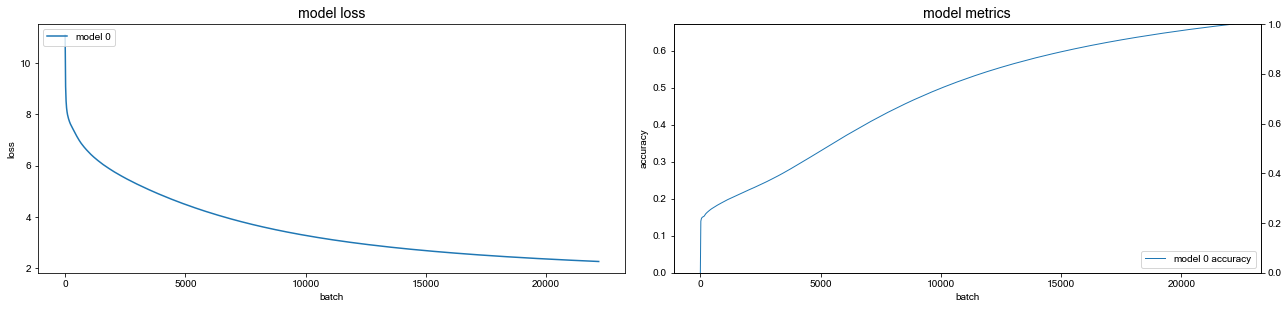

model 0           first_layer gradients: 2.528e+01| last_layer gradients: 8.765e+00
model 0      Step: 24s47ms  | Loss: 2.253 | accuracy: 67.236%  | lr: 1.000e-03  | epoch: 49  ( 300/447 )
model 0      Step: 23s846ms | Loss: 2.252 | accuracy: 67.251%  | lr: 1.000e-03  | epoch: 49  ( 320/447 )
model 0      Step: 23s974ms | Loss: 2.252 | accuracy: 67.266%  | lr: 1.000e-03  | epoch: 49  ( 340/447 )
model 0      Step: 23s472ms | Loss: 2.251 | accuracy: 67.280%  | lr: 1.000e-03  | epoch: 49  ( 360/447 )
model 0      Step: 23s979ms | Loss: 2.250 | accuracy: 67.295%  | lr: 1.000e-03  | epoch: 49  ( 380/447 )
model 0      Step: 23s757ms | Loss: 2.249 | accuracy: 67.310%  | lr: 1.000e-03  | epoch: 49  ( 400/447 )
model 0      Step: 24s154ms | Loss: 2.248 | accuracy: 67.325%  | lr: 1.000e-03  | epoch: 49  ( 420/447 )
model 0      Step: 24s291ms | Loss: 2.248 | accuracy: 67.340%  | lr: 1.000e-03  | epoch: 49  ( 440/447 )


In [12]:

lstm_poet2\
    .with_optimizer(optimizer='Adam',lr=1e-4,betas=(0.9, 0.999))\
    .with_loss(SequenceCrossEntropyLoss)\
    .with_metric(SequenceAccuracy,name='accuracy')\
    .with_regularizer('l2')\
    .with_model_save_path('Models/{0}.pth.tar'.format(item))\
    .trigger_when('on_batch_end', action=write_something,frequency=200,unit='batch') \
    .with_learning_rate_scheduler(reduce_lr_on_plateau,monitor='accuracy',mode='max',factor=0.5,patience=3,cooldown=0,threshold=5e-4,warmup=0) \
    .with_automatic_mixed_precision_training()

    #.with_optimizer(optimizer='Adam',lr=1e-3,betas=(0.9, 0.999))\ 設定優化器
    #.with_loss(SequenceCrossEntropyLoss)\ 設定損失函數
    #.with_metric(SequenceAccuracy,name='accuracy')\ 設定評估函數
    #.with_regularizer('l2')\ 設定l2regularizer
    #.with_model_save_path('Models/{0}.pth.tar'.format(item))\ 設定模型存檔路徑
    #.trigger_when('on_batch_end', action=write_something) \ #設定觸發任務write_something
    #設定調整學習速率時程
    #.with_learning_rate_scheduler(reduce_lr_on_plateau,monitor='accuracy',mode='max',factor=0.5,patience=3,cooldown=0,threshold=5e-4,warmup=0) \
    #.with_automatic_mixed_precision_training() #設定為自動混合精度訓練
    

plan=TrainingPlan()\
    .add_training_item(lstm_poet2)\
    .with_data_loader(data_provider)\
    .repeat_epochs(50)\
    .with_batch_size(32)\
    .print_progress_scheduling(20,unit='batch')\
    .display_loss_metric_curve_scheduling(frequency=200,unit='batch',imshow=True)\
    .print_gradients_scheduling(200)\
    .save_model_scheduling(50,unit='batch')

    #.add_training_item(lstm_poet2)\ 加入要訓練的模型
    #.with_data_loader(data_provider)\ 設定資料提供者
    #.repeat_epochs(50)\  設定總epoch數
    #.with_batch_size(32)\ 設定批次大小
    #.print_progress_scheduling(20,unit='batch')\ 設定列印訓練狀態的時程
    #.display_loss_metric_curve_scheduling(frequency=200,unit='batch',imshow=True)\ 設定顯示loss-metrics時間走勢圖的時程
    #.print_gradients_scheduling(200)\ 設定列印梯度狀況的時程
    #.save_model_scheduling(50,unit='batch') 設定存檔的時程


plan.start_now()



In [17]:
#寫藏頭詩
def get_hidden_poetry(heading,temperature = 1.8):

    model =load('Models/{0}_3.pth'.format(item))
    # 模型千萬記得要轉換成eval模式
    model.eval()
    for  module in model.modules():
        if isinstance(module, LSTM):
            module.stateful=True
    #清除模型狀態
    for module in model.modules():
        if isinstance(module, LSTM):
            module.clear_state()
    
    model.eval()
    

    print()
    print('----- 以「{0}」寫藏頭詩'.format(heading))

    print('----- temperature:', temperature)

    
    text_generated = []
    heading_idx=0
    start_string = heading[heading_idx]
    text_generated.append('[CLS]')
    text_generated.append(heading[heading_idx])
    
    heading_idx+=1


    seq = [data_provider.text2index(s) for s in start_string]
    seq.insert(0, 0)
    # seq.append(1)
    input_eval = to_tensor([seq]).long().detach()
    if ndim(input_eval)<2:
        input_eval=input_eval.expand_dims(0)


    is_finished = False
    num_generate = 0
    row_length=0

    sys.stdout.write(start_string)

    while not is_finished:
        try:

            predictions = model(input_eval)[-1]
            #將溫度設定僅限於機率最高的十個字
            predicted_idx=argsort(predictions)[:10]
            predicted_probs =  clip(predictions[predicted_idx],1e-8,1-1e-8)

            predicted_id = predicted_idx[multinomial(predicted_probs/ temperature, num_samples=1)].item()
            
            input_eval = to_tensor([[predicted_id]]).long().detach()
            

            if text_generated[-1]==' ' and heading_idx<len(heading):
                text_generated.append(heading[heading_idx])
                #更新字頭 覆寫成為下次的輸入
                input_eval = to_tensor([[data_provider.text2index(heading[heading_idx])]]).long().detach()
                heading_idx+=1
            else:
                text_generated.append(data_provider.index2text(predicted_id))
            
            
            if ndim(input_eval) < 2:
                input_eval = input_eval.expand_dims(0)
                
            
            if len(text_generated)>10 and len(list(set(text_generated[-5:])))==1:
                is_finished = True

                break
            if text_generated[-2] == '[PAD]' and text_generated[-1] == '[PAD]':
                sys.stdout.write('\n\n')
                sys.stdout.flush()
                is_finished = True
            if text_generated[-1] == '[SEP]' :
                sys.stdout.write('\n')
                sys.stdout.flush()
            elif text_generated[-1] not in ['[CLS]','[PAD]','[UNK]']:
                sys.stdout.write(text_generated[-1])
                row_length += 1
                if row_length >= 47 and text_generated[-1] in ['，', '。',' ', '[SEP]']:
                    sys.stdout.write('\n')
                    is_finished=True
                sys.stdout.flush()
            num_generate += 1
        except Exception as e:
            print(e)
    model.train()
    print()
    



In [18]:
get_hidden_poetry('白日依山黃河入海')


----- 以「白日依山黃河入海」寫藏頭詩
----- temperature: 1.8
白髮添雙鬢 日空又一年 依應遣支遁 山多借歸耕 黃葉風吹砌 河池島倒松 入吟風雪裏 海雪自相連





In [19]:
get_hidden_poetry('沉魚落雁閉月羞花',1.2)


----- 以「沉魚落雁閉月羞花」寫藏頭詩
----- temperature: 1.2
沉心何處遂 魚戲滿空廊 落葉不離水 雁聲時出山 閉門誰得意 月月豈同人 羞此心相似 花開又一年





In [26]:
get_hidden_poetry('疫情當頭台灣加油')


----- 以「疫情當頭台灣加油」寫藏頭詩
----- temperature: 1.8
疫茸藏良日 情王覽舊時 當年芸閣吏 頭命赤泥僮 台嶺收兵劒 灣宮阻故人 加朝觀藁婦 油蓋向皇州



